In [1]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt

In [2]:
# the features are separated into sequences of 128 days, 4 price features and 1 volume feature
seq_len = 128

# during a single step the model receives 32 sequences 
batch_size = 32

"""
Our transformer model will have an input size of (32, 128, 5)
32 -> batch sie
128 -> sequence length
5 -> number of features
"""

'\nOur transformer model will have an input size of (32, 128, 5)\n32 -> batch sie\n128 -> sequence length\n5 -> number of features\n'

In [3]:
# Stock for the deep learning
ticker = "GOOGL"

In [4]:
# Importing dataset (use the function in data/data.py)
df = pd.read_csv("data/data.csv", usecols=["Date", "High", "Low", "Open", "Close", "Volume"])

# Selection of columns
# df = df[["Date", "High", "Low", "Open", "Close", "Volume"]]

# Avoid dividing by 0
df['Volume'].replace(to_replace=0, method='ffill', inplace=True)

# Sort the values based on date
df.sort_values('Date', inplace=True)

df.tail()

,Date,High,Low,Open,Close,Volume
6661,2022-11-14,96.790001,94.510002,95.089996,95.699997,30179500.0
6662,2022-11-15,100.139999,96.709999,98.260002,98.440002,41640800.0
6663,2022-11-16,99.639999,97.639999,97.900002,98.849998,29105200.0
6664,2022-11-17,99.279999,96.790001,96.970001,98.360001,26052600.0
6665,2022-11-18,98.900002,96.370003,98.769997,97.430000,28328800.0


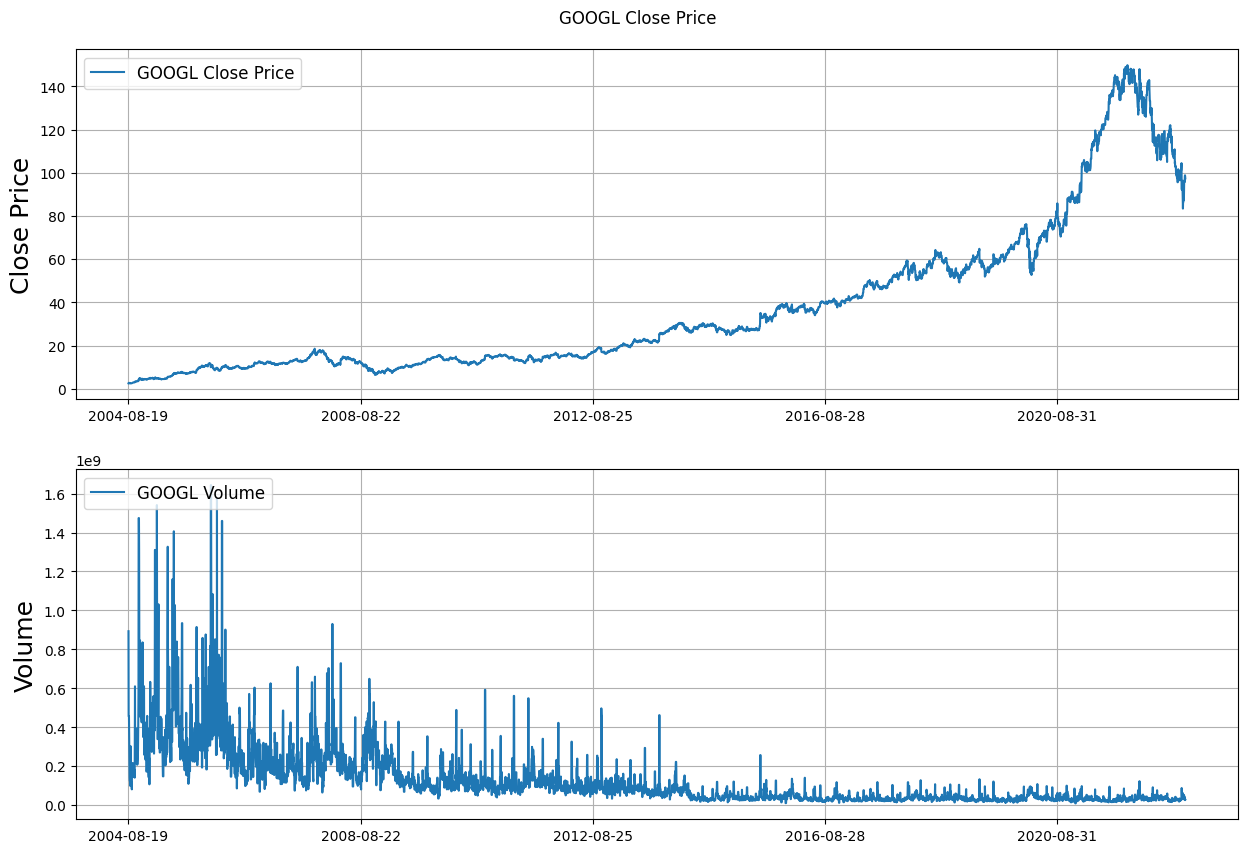

In [5]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle(f"{ticker} Close Price")
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label=f'{ticker} Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)
ax1.grid()

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label=f'{ticker} Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)
ax2.grid()

## Data normalization 
- Insetead of the values we keep the percentage of change
- Get the separation index values
- Get the min and max returns
- Normalize the data with the max and min (0-1 range)

In [6]:
df['Open'] = df['Open'].pct_change() # Create arithmetic returns column
df['High'] = df['High'].pct_change() # Create arithmetic returns column
df['Low'] = df['Low'].pct_change() # Create arithmetic returns column
df['Close'] = df['Close'].pct_change() # Create arithmetic returns column
df['Volume'] = df['Volume'].pct_change()

# Drop the rows with the NaN created by the percentage change
df.dropna(how="any", axis=0, inplace=True)

In [7]:
# Get the values to create the separation of the dataset
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))]
last_20pct = sorted(df.index.values)[-int(0.2*len(times))]

In [8]:
# min-max price columns
min_return = min(df[(df.index<last_20pct)][["Open", "High", "Low", "Close"]].min(axis=0))
max_return = max(df[(df.index<last_20pct)][["Open", "High", "Low", "Close"]].max(axis=0))

# Min-max normalize price columns (0-1 range)
df["Open"] = (df["Open"] - min_return) / (max_return - min_return)
df["High"] = (df["High"] - min_return) / (max_return - min_return)
df["Low"] = (df["Low"] - min_return) / (max_return - min_return)
df["Close"] = (df["Close"] - min_return) / (max_return - min_return)

In [9]:
# min-max volume column
min_volume = df[(df.index<last_20pct)]["Volume"].min(axis=0)
max_volume = df[(df.index<last_20pct)]["Volume"].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df["Volume"] = (df["Volume"] - min_volume) / (max_volume - min_volume)

## Split the data 
- Split into train, the first 80% of the data
- Split into validation, between the first 80% and 90% of the data
- Split into test, between 90% and tha 100% of the data

In [10]:
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

In [11]:
# Drop the date column from the splitted datasets
df_train.drop(columns=["Date"], inplace=True)
df_val.drop(columns=["Date"], inplace=True)
df_test.drop(columns=["Date"], inplace=True)

/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/965977957.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=["Date"], inplace=True)
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/965977957.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=["Date"], inplace=True)
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/965977957.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [12]:
# Train data into arrays np.ndarray
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (5332, 5)
Validation data shape: (667, 5)
Test data shape: (666, 5)


In [13]:
df_train.head()

,High,Low,Open,Close,Volume
1,0.519737,0.516795,0.399106,0.618376,0.055513
2,0.367163,0.367163,0.367163,0.367163,0.149419
3,0.367163,0.367163,0.367163,0.367163,0.149419
4,0.494738,0.636230,0.672131,0.398992,0.110893
5,0.314767,0.208230,0.381155,0.236202,0.117750


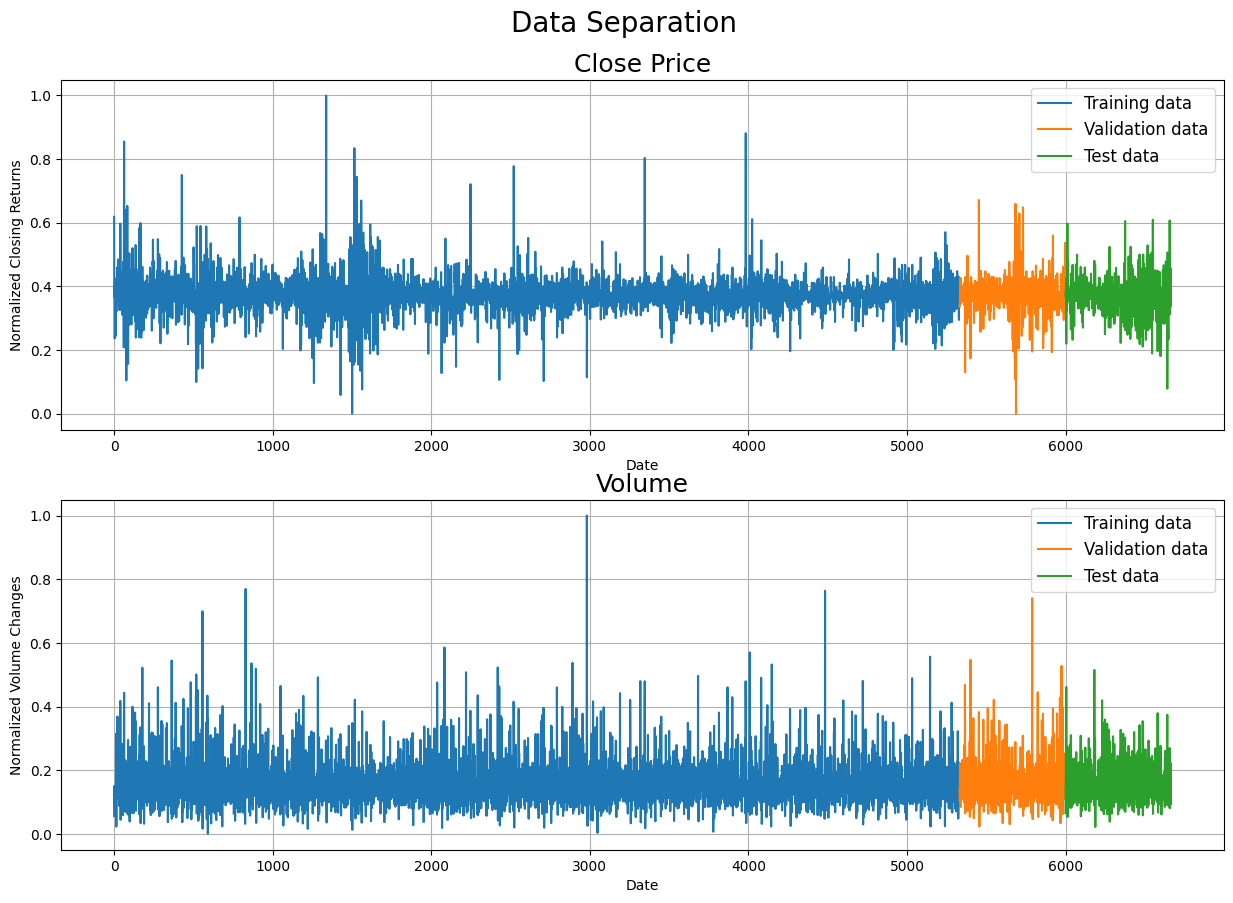

In [14]:
fig = plt.figure(figsize=(15, 10))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')
ax1.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')
ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)
ax1.grid()

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')
ax2.plot(np.arange(train_data.shape[0], train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')
ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)
ax2.grid()

In [15]:
def divide_data_x_y(data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    X, y = [], []

    for i in range(seq_len, len(data)):
        # Chunks of  data with a length of 128 df-rows
        X.append(data[i-seq_len:i])
        
        # Value of 4th column (Close Price) of df-row 128+1
        y.append(data[:, 3][i])

    X, y = np.array(X), np.array(y)
    return X, y

In [16]:
# Training data
X_train_test, y_train_test = divide_data_x_y(train_data)

# Validation data
X_val_test, y_val_test = divide_data_x_y(val_data)

# Test data
X_test_test, y_test_test = divide_data_x_y(test_data)

# Shape of the elements
print('Training set shape', X_train_test.shape, y_train_test.shape)
print('Validation set shape', X_val_test.shape, y_val_test.shape)
print('Testing set shape' ,X_test_test.shape, y_test_test.shape)

Training set shape (5204, 128, 5) (5204,)
Validation set shape (539, 128, 5) (539,)
Testing set shape (538, 128, 5) (538,)


In [17]:
torch.FloatTensor(X_train).shape


NameError: name 'X_train' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

(5204, 128, 5)

In [ ]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor

class PositionalEncoder(nn.Module):
    """
    The authors of the original transformer paper describe very succinctly what 
    the positional encoding layer does and why it is needed:
    
    "Since our model contains no recurrence and no convolution, in order for the 
    model to make use of the order of the sequence, we must inject some 
    information about the relative or absolute position of the tokens in the 
    sequence." (Vaswani et al, 2017)
    Adapted from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=5000, 
        d_model: int=512,
        batch_first: bool=False
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
                     (Vaswani et al, 2017)
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        self.x_dim = 1 if batch_first else 0

        # copy pasted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_seq_len, 1, d_model)
        
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """

        x = x + self.pe[:x.size(self.x_dim)]

        return self.dropout(x)

In [ ]:
from torch import nn, Tensor
import torch.nn.functional as F

class TimeSeriesTransformer(nn.Module):

    """
    This class implements a transformer model that can be used for times series
    forecasting. This time series transformer model is based on the paper by
    Wu et al (2020) [1]. The paper will be referred to as "the paper".
    A detailed description of the code can be found in my article here:
    https://towardsdatascience.com/how-to-make-a-pytorch-transformer-for-time-series-forecasting-69e073d4061e
    In cases where the paper does not specify what value was used for a specific
    configuration/hyperparameter, this class uses the values from Vaswani et al
    (2017) [2] or from PyTorch source code.
    Unlike the paper, this class assumes that input layers, positional encoding 
    layers and linear mapping layers are separate from the encoder and decoder, 
    i.e. the encoder and decoder only do what is depicted as their sub-layers 
    in the paper. For practical purposes, this assumption does not make a 
    difference - it merely means that the linear and positional encoding layers
    are implemented inside the present class and not inside the 
    Encoder() and Decoder() classes.
    [1] Wu, N., Green, B., Ben, X., O'banion, S. (2020). 
    'Deep Transformer Models for Time Series Forecasting: 
    The Influenza Prevalence Case'. 
    arXiv:2001.08317 [cs, stat] [Preprint]. 
    Available at: http://arxiv.org/abs/2001.08317 (Accessed: 9 March 2022).
    [2] Vaswani, A. et al. (2017) 
    'Attention Is All You Need'.
    arXiv:1706.03762 [cs] [Preprint]. 
    Available at: http://arxiv.org/abs/1706.03762 (Accessed: 9 March 2022).
    """

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool=True,
        out_seq_len: int=58,
        dim_val: int=512,  
        n_encoder_layers: int=4,
        n_decoder_layers: int=4,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        num_predicted_features: int=1
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            n_decoder_layers: int, number of stacked encoder layers in the decoder
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            dropout_decoder: float, the dropout rate of the decoder
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            dim_feedforward_decoder: int, number of neurons in the linear layer 
                                     of the decoder
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 because we're
                                    only forecasting FCR-N prices in DK2, but in
                                    we wanted to also predict FCR-D with the same
                                    model, num_predicted_features should be 2.
        """

        super().__init__() 

        self.dec_seq_len = dec_seq_len

        #print("input_size is: {}".format(input_size))
        #print("dim_val is: {}".format(dim_val))

        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=input_size, 
            out_features=dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=num_predicted_features,
            out_features=dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=dim_val, 
            out_features=num_predicted_features
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=dim_val,
            dropout=dropout_pos_enc
            )

        # The encoder layer used in the paper is identical to the one used by
        # Vaswani et al (2017) on which the PyTorch module is based.
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val, 
            nhead=n_heads,
            dim_feedforward=dim_feedforward_encoder,
            dropout=dropout_encoder,
            batch_first=batch_first
            )

        # Stack the encoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerEncoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_decoder,
            dropout=dropout_decoder,
            batch_first=batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        # It seems the option of passing a normalization instance is redundant
        # in my case, because nn.TransformerDecoderLayer per default normalizes
        # after each sub-layer
        # (https://github.com/pytorch/pytorch/issues/24930).
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: (S,E) for unbatched input, 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: (T,E) for unbatched input, 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder
        # Masking is only needed in the encoder if input sequences are padded
        # which they are not in this time series use case, because all my
        # input sequences are naturally of the same length. 
        # (https://github.com/huggingface/transformers/issues/4083)
        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output

In [ ]:
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 1 # The number of input variables. 1 if univariate forecasting.
dec_seq_len = 92 # length of input given to decoder. Can have any integer value.
enc_seq_len = 153 # length of input given to encoder. Can have any integer value.
output_sequence_length = 58 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    #max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads)

<>:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/3403743226.py:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.FloatTensor(inout_seq)


torch.Size([2695, 2, 100])


/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/3403743226.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 10 is 0):
/opt/miniconda3/envs/TAAC_project/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    53/  269 batches | lr 0.005000 | 48.51 ms | loss 5.53434 | ppl   253.24
| epoch   1 |   106/  269 batches | lr 0.005000 | 43.88 ms | loss 0.15548 | ppl     1.17
| epoch   1 |   159/  269 batches | lr 0.005000 | 43.06 ms | loss 0.15475 | ppl     1.17
| epoch   1 |   212/  269 batches | lr 0.005000 | 42.58 ms | loss 0.15133 | ppl     1.16
| epoch   1 |   265/  269 batches | lr 0.005000 | 43.27 ms | loss 0.12951 | ppl     1.14
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 12.64s | valid loss 0.42977 | valid ppl     1.54
-----------------------------------------------------------------------------------------
| epoch   2 |    53/  269 batches | lr 0.004802 | 43.03 ms | loss 0.12798 | ppl     1.14
| epoch   2 |   106/  269 batches | lr 0.004802 | 42.44 ms | loss 0.08025 | ppl     1.08
| epoch   2 |   159/  269 batches | lr 0.004802 | 42.17 ms | loss 0.09339 | ppl     1.10
| epoch   2 |   212/  269 batche

/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/3403743226.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 10 is 0):
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/3403743226.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 10 is 0):
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/3403743226.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 10 is 0):
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_1362/3403743226.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if(epoch % 10 is 0):


FileNotFoundError: [Errno 2] No such file or directory: 'graph/transformer-epoch10.png'

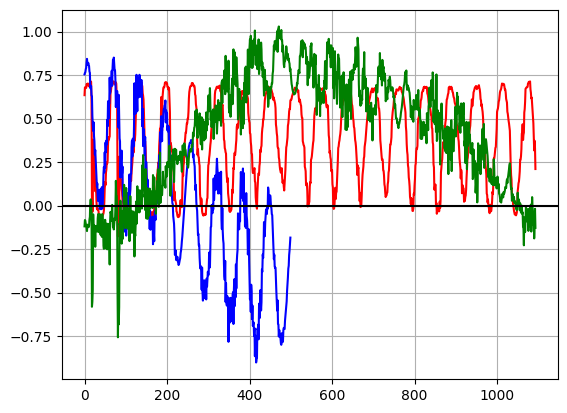

In [18]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
from matplotlib import pyplot

torch.manual_seed(0)
np.random.seed(0)

# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)

input_window = 100
output_window = 5
batch_size = 10 # batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print("______")
        # # print(x)
        # print(x.shape)
        # # print(self.pe)
        # print(self.pe.shape)
        # print("______")

        return x + self.pe[:x.size(0), :]
       

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask



# if window is 100 and prediction step is 1
# in -> [0..99]
# target -> [1..100]
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

def get_data():
    time        = np.arange(0, 400, 0.1)
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    
    
    sampels = 2800
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    inputs, targets = [], []

    for i in range(128, len(X_train_test)):
        # Chunks of  data with a length of 128 df-rows
        inputs.append(X_train_test[i-seq_len:i])
        
        # Value of 4th column (Close Price) of df-row 128+1
        targets.append(X_train_test[:, 3][i])
    
    inputs, targets = torch.FloatTensor(np.array(inputs)), torch.FloatTensor(np.array(targets))

    return train_sequence.to(device),test_data.to(device)

def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target


def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):

        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        # print(data.size())
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)

    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:500],color="blue")
    pyplot.plot(test_result-truth,color="green")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()
    
    return total_loss / i


def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.close()
        
# entweder ist hier ein fehler im loss oder in der train methode, aber die ergebnisse sind unterschiedlich 
# auch zu denen der predict_future
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

train_data, val_data = get_data()
print(train_data.size())
model = TransAm().to(device)

criterion = nn.MSELoss()
lr = 0.005 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    
    if(epoch % 10 is 0):
        val_loss = plot_and_loss(model, val_data,epoch)
        predict_future(model, val_data,200)
    else:
        val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    #if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

In [8]:
train_data.size()

torch.Size([2695, 2, 100])

In [1]:
import numpy as np 
import torch
input_window = 100
output_window = 5
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
        
    return torch.FloatTensor(inout_seq)

def get_data():
    time        = np.arange(0, 400, 0.1)
    amplitude   = np.sin(time) + np.sin(time*0.05) +np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)
    
    
    sampels = 2800
    train_data = amplitude[:sampels]
    test_data = amplitude[sampels:]

    # convert our train data into a pytorch train tensor
    #train_tensor = torch.FloatTensor(train_data).view(-1)
    # todo: add comment.. 
    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window] #todo: fix hack?

    #test_data = torch.FloatTensor(test_data).view(-1) 
    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window] #todo: fix hack?

    return train_sequence,test_data
train_data, val_data = get_data()

AttributeError: 'list' object has no attribute 'shape'

In [7]:
len(train_data[0][0])

100